In [ ]:
!pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install opencv-python mediapipe scikit-learn matplotlib seaborn pandas numpy tqdm pathlib
!pip install dlib

^C



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached dlib-19.24.9.tar.gz (3.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for dlib: started
  Running setup.py install for dlib: finished with status 'error'


  DEPRECATION: dlib is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  × Running setup.py install for dlib did not run successfully.
  │ exit code: 1
  ╰─> [43 lines of output]
      running install
      C:\Users\finda\Downloads\deepfake_dataset\new\Lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running build_ext
      
      
                         CMake is not installed on your system!
      
          Or it is possible some broken copy of cmake is installed on your system.
          It is unfortunately ver

Looking in indexes: https://download.pytorch.org/whl/cu118
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata (29 kB)
  Obtaining dependency information for torchvision from https://download.pytorch.org/whl/cu118/torchvision-0.22.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://download.pytorch.org/whl/cu118/torchaudio-2.7.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for filelock from https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Obtaining dependency information for typing-extensions>=4.10.0 from https://download.pytorch.org/whl/typing_extensions-4.12.2-py3-none-any.w

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\finda\\Downloads\\deepfake_dataset\\new\\Lib\\site-packages\\~-mpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll'
Check the permissions.


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import urllib.request
import os

if not os.path.exists('shape_predictor_68_face_landmarks.dat'):
    print("Downloading dlib face landmark predictor...")
    urllib.request.urlretrieve(
        'https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2',
        'shape_predictor_68_face_landmarks.dat.bz2'
    )
    import bz2
    with bz2.BZ2File('shape_predictor_68_face_landmarks.dat.bz2') as fr, open('shape_predictor_68_face_landmarks.dat', 'wb') as fw:
        fw.write(fr.read())
    print("Download complete!")

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import mediapipe as mp
import json
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

print("✅ All libraries imported.")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🖥️ CUDA available: {torch.cuda.is_available()}")

✅ All libraries imported.
🔥 PyTorch version: 2.5.1+cpu
🖥️ CUDA available: False


In [ ]:
# CHANGE THIS TO YOUR DATASET LOCATION
DATA_ROOT = r"C:\Users\finda\Downloads\deepfake_dataset\deepfake_dataset"  # e.g., r"D:/DeepfakeDataset"
OUTPUT_DIR = r"C:\Users\finda\Downloads\deepfake_dataset\ouput"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure output directory exists
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(f"📁 Data root: {DATA_ROOT}")
print(f"💾 Output dir: {OUTPUT_DIR}")
print(f"🚀 Running on: {DEVICE}")

# Check structure of dataset
try:
    train_real_path = Path(DATA_ROOT) / 'train' / 'real'
    train_fake_path = Path(DATA_ROOT) / 'train' / 'fake'
    test_real_path = Path(DATA_ROOT) / 'test' / 'real'
    test_fake_path = Path(DATA_ROOT) / 'test' / 'fake'

    print(f"\n🔍 Dataset stats:")
    print(f"Train Real: {len(list(train_real_path.glob('*.mp4')))} videos")
    print(f"Train Fake: {len(list(train_fake_path.glob('*.mp4')))} videos")
    print(f"Test Real: {len(list(test_real_path.glob('*.mp4')))} videos")
    print(f"Test Fake: {len(list(test_fake_path.glob('*.mp4')))} videos")
except Exception as e:
    print(f"Error checking dataset structure: {e}")


📁 Data root: C:\Users\finda\Downloads\deepfake_dataset\deepfake_dataset
💾 Output dir: C:\Users\finda\Downloads\deepfake_dataset\ouput
🚀 Running on: cpu

🔍 Dataset stats:
Train Real: 180 videos
Train Fake: 180 videos
Test Real: 20 videos
Test Fake: 20 videos


DATA PREPROCESSING

In [ ]:
pip install dlib

  Using cached dlib-19.24.9.tar.gz (3.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for dlib: started
  Running setup.py install for dlib: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: dlib is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  × Running setup.py install for dlib did not run successfully.
  │ exit code: 1
  ╰─> [43 lines of output]
      running install
      c:\Users\finda\Downloads\deepfake_dataset\new\Lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running build_ext
      
      
                         CMake is not installed on your system!
      
          Or it is possible some broken copy of cmake is installed on your system.
          It is unfortunately ver

In [ ]:
class VideoPreprocessor:
    def __init__(self):
        # Initialize MediaPipe components
        self.mp_face_detection = mp.solutions.face_detection
        self.mp_face_mesh = mp.solutions.face_mesh
        self.mp_pose = mp.solutions.pose
        
        self.face_detection = self.mp_face_detection.FaceDetection(
            model_selection=0, min_detection_confidence=0.5
        )
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=False, max_num_faces=1, 
            refine_landmarks=True, min_detection_confidence=0.5
        )
        self.pose = self.mp_pose.Pose(
            static_image_mode=False, model_complexity=1, 
            smooth_landmarks=True, min_detection_confidence=0.5
        )
        
        # Try to initialize dlib (optional)
        try:
            import dlib
            self.dlib_detector = dlib.get_frontal_face_detector()
            self.dlib_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
            self.dlib_available = True
            print("Dlib initialized successfully")
        except:
            self.dlib_available = False
            print("Dlib not available, using MediaPipe only")

# Initialize preprocessor
preprocessor = VideoPreprocessor()
print("Preprocessor initialized!")

Dlib not available, using MediaPipe only
Preprocessor initialized!


Define Frame Extraction Function

In [ ]:
def extract_frames_from_video(video_path, max_frames=30, target_fps=10):
    """Extract frames from video with consistent sampling"""
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return []
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate frame sampling
    frame_interval = max(1, int(fps / target_fps)) if fps > 0 else 1
    frames_to_extract = min(max_frames, total_frames // frame_interval)
    
    frames = []
    frame_count = 0
    extracted_count = 0
    
    while cap.isOpened() and extracted_count < frames_to_extract:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % frame_interval == 0:
            # Resize frame for consistent processing
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
            extracted_count += 1
        
        frame_count += 1
    
    cap.release()
    return frames

In [ ]:
# Test frame extraction on a sample video
print("Testing frame extraction...")
sample_videos = list(Path(DATA_ROOT).rglob('*.mp4'))[:2]  # Test on first 2 videos
for video_path in sample_videos:
    frames = extract_frames_from_video(video_path)
    print(f"{video_path.name}: {len(frames)} frames extracted")

Testing frame extraction...
06_15__walking_and_outside_surprised__QRCD27P8.mp4: 30 frames extracted
07_03__hugging_happy__7NGMD8FT.mp4: 30 frames extracted


In [ ]:
def extract_facial_landmarks(frame, preprocessor):
    """Extract facial landmarks using MediaPipe"""
    landmarks = {}
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # MediaPipe face mesh
    try:
        results = preprocessor.face_mesh.process(rgb_frame)
        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]
            mp_landmarks = []
            for landmark in face_landmarks.landmark:
                mp_landmarks.append([landmark.x, landmark.y, landmark.z])
            landmarks['mediapipe'] = np.array(mp_landmarks)
        else:
            landmarks['mediapipe'] = None
    except:
        landmarks['mediapipe'] = None
    
    return landmarks

In [ ]:
def extract_pose_landmarks(frame, preprocessor):
    """Extract pose landmarks"""
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = preprocessor.pose.process(rgb_frame)
    
    if results.pose_landmarks:
        pose_landmarks = []
        for landmark in results.pose_landmarks.landmark:
            pose_landmarks.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
        return np.array(pose_landmarks)
    return None

In [ ]:
def calculate_frame_features(frame):
    """Calculate various frame-level features"""
    features = {}
    
    # Basic image statistics
    features['mean_intensity'] = float(np.mean(frame))
    features['std_intensity'] = float(np.std(frame))
    features['brightness'] = float(np.mean(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)))
    
    # Color distribution
    for i, color in enumerate(['b', 'g', 'r']):
        features[f'{color}_mean'] = float(np.mean(frame[:, :, i]))
        features[f'{color}_std'] = float(np.std(frame[:, :, i]))
    
    # Edge density
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    features['edge_density'] = float(np.sum(edges > 0) / (edges.shape[0] * edges.shape[1]))
    
    # Blur detection (Laplacian variance)
    features['blur_score'] = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    
    return features

print("Feature extraction functions defined!")


Feature extraction functions defined!


In [ ]:
def process_single_video(video_path, label, preprocessor):
    """Process a single video and extract all features"""
    frames = extract_frames_from_video(video_path)
    
    if not frames:
        return None
    
    video_data = {
        'path': str(video_path),
        'label': label,
        'num_frames': len(frames),
        'frames': [],
        'temporal_features': {}
    }
    
    # Process each frame
    all_facial_landmarks = []
    all_pose_landmarks = []
    all_frame_features = []
    
    for i, frame in enumerate(frames):
        frame_data = {
            'frame_id': i,
            'facial_landmarks': extract_facial_landmarks(frame, preprocessor),
            'pose_landmarks': extract_pose_landmarks(frame, preprocessor),
            'frame_features': calculate_frame_features(frame)
        }
        
        video_data['frames'].append(frame_data)
        
        # Collect for temporal analysis
        if frame_data['facial_landmarks'].get('mediapipe') is not None:
            all_facial_landmarks.append(frame_data['facial_landmarks']['mediapipe'])
        if frame_data['pose_landmarks'] is not None:
            all_pose_landmarks.append(frame_data['pose_landmarks'])
        all_frame_features.append(frame_data['frame_features'])
    
    # Calculate temporal features
    video_data['temporal_features'] = calculate_temporal_features(
        all_facial_landmarks, all_pose_landmarks, all_frame_features
    )
    
    return video_data

def calculate_temporal_features(facial_landmarks, pose_landmarks, frame_features):
    """Calculate temporal consistency features"""
    temporal_features = {}
    
    # Facial landmark temporal analysis
    if len(facial_landmarks) > 1:
        facial_landmarks = np.array(facial_landmarks)
        facial_movement = np.diff(facial_landmarks, axis=0)
        temporal_features['facial_movement_variance'] = float(np.var(facial_movement))
        temporal_features['facial_jitter'] = float(np.mean(np.std(facial_movement, axis=1)))
    
    # Pose landmark temporal analysis
    if len(pose_landmarks) > 1:
        pose_landmarks = np.array(pose_landmarks)
        pose_movement = np.diff(pose_landmarks, axis=0)
        temporal_features['pose_movement_variance'] = float(np.var(pose_movement))
        temporal_features['pose_jitter'] = float(np.mean(np.std(pose_movement, axis=1)))
    
    # Frame feature temporal analysis
    if len(frame_features) > 1:
        feature_df = pd.DataFrame(frame_features)
        for col in feature_df.columns:
            temporal_features[f'{col}_temporal_std'] = float(feature_df[col].std())
            if len(feature_df) > 2:
                temporal_features[f'{col}_temporal_trend'] = float(
                    np.polyfit(range(len(feature_df)), feature_df[col], 1)[0]
                )
    
    return temporal_features
# Test processing on a few sample videos
print("Testing video processing...")
sample_videos = list(Path(DATA_ROOT).rglob('*.mp4'))[:3]  # Test on first 3 videos

for i, video_path in enumerate(sample_videos):
    label = 1 if 'fake' in str(video_path) else 0
    print(f"\nProcessing {video_path.name} (Label: {'Fake' if label else 'Real'})")
    
    result = process_single_video(video_path, label, preprocessor)
    if result:
        print(f"  - Frames processed: {result['num_frames']}")
        print(f"  - Temporal features: {len(result['temporal_features'])}")
        print(f"  - Sample frame features: {len(result['frames'][0]['frame_features'])}")
    else:
        print(f"  - Failed to process")

Testing video processing...

Processing 06_15__walking_and_outside_surprised__QRCD27P8.mp4 (Label: Fake)
  - Frames processed: 30
  - Temporal features: 26
  - Sample frame features: 11

Processing 07_03__hugging_happy__7NGMD8FT.mp4 (Label: Fake)
  - Frames processed: 30
  - Temporal features: 26
  - Sample frame features: 11

Processing 07_14__exit_phone_room__P9QFO50U.mp4 (Label: Fake)
  - Frames processed: 30
  - Temporal features: 24
  - Sample frame features: 11


In [ ]:
def load_all_video_paths(data_root):
    """Load and organize all video paths"""
    data_root = Path(data_root)
    
    train_real = list((data_root / 'train' / 'real').glob('*.mp4'))
    train_fake = list((data_root / 'train' / 'fake').glob('*.mp4'))
    test_real = list((data_root / 'test' / 'real').glob('*.mp4'))
    test_fake = list((data_root / 'test' / 'fake').glob('*.mp4'))
    
    dataset_info = {
        'train': {
            'real': train_real,
            'fake': train_fake,
        },
        'test': {
            'real': test_real,
            'fake': test_fake,
        }
    }
    
    print(f"Dataset loaded:")
    print(f"  Train: {len(train_real)} real + {len(train_fake)} fake = {len(train_real) + len(train_fake)} total")
    print(f"  Test: {len(test_real)} real + {len(test_fake)} fake = {len(test_real) + len(test_fake)} total")
    
    return dataset_info

# Load dataset
dataset_info = load_all_video_paths(DATA_ROOT)


Dataset loaded:
  Train: 180 real + 180 fake = 360 total
  Test: 20 real + 20 fake = 40 total


In [ ]:
from torch.utils.data import Dataset

class DeepfakeDataset(Dataset):
    """PyTorch Dataset for deepfake detection"""
    
    def __init__(self, data, feature_type='combined'):
        self.data = data
        self.feature_type = feature_type
        self.samples = []
        self.prepare_samples()
    
    def prepare_samples(self):
        """Prepare samples based on feature type"""
        for video in self.data:
            if self.feature_type == 'frame_features':
                # Use aggregated frame features
                features = []
                for frame in video['frames']:
                    frame_feat = list(frame['frame_features'].values())
                    features.extend(frame_feat)
                
                # Pad or truncate to fixed size
                target_size = 300
                if len(features) < target_size:
                    features.extend([0] * (target_size - len(features)))
                else:
                    features = features[:target_size]
                
                self.samples.append({
                    'features': np.array(features, dtype=np.float32),
                    'label': video['label']
                })
            
            elif self.feature_type == 'temporal_features':
                # Use temporal features
                temp_features = list(video['temporal_features'].values())
                if temp_features:
                    # Handle NaN values
                    temp_features = [f if not np.isnan(f) else 0 for f in temp_features]
                    # Pad to consistent size
                    target_size = 50
                    if len(temp_features) < target_size:
                        temp_features.extend([0] * (target_size - len(temp_features)))
                    else:
                        temp_features = temp_features[:target_size]
                    
                    self.samples.append({
                        'features': np.array(temp_features, dtype=np.float32),
                        'label': video['label']
                    })
            
            elif self.feature_type == 'combined':
                # Combine frame and temporal features
                frame_features = []
                for frame in video['frames']:
                    frame_feat = list(frame['frame_features'].values())
                    frame_features.extend(frame_feat)
                
                temporal_features = list(video['temporal_features'].values())
                temporal_features = [f if not np.isnan(f) else 0 for f in temporal_features]
                
                combined_features = frame_features + temporal_features
                
                # Normalize length
                target_size = 350
                if len(combined_features) < target_size:
                    combined_features.extend([0] * (target_size - len(combined_features)))
                else:
                    combined_features = combined_features[:target_size]
                
                self.samples.append({
                    'features': np.array(combined_features, dtype=np.float32),
                    'label': video['label']
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        features = torch.FloatTensor(sample['features'])
        label = torch.LongTensor([sample['label']])
        
        return features, label

print("Dataset class defined!")

Dataset class defined!


In [ ]:
class DeepfakeDataset(Dataset):
    """PyTorch Dataset for deepfake detection"""
    
    def __init__(self, data, feature_type='combined'):
        self.data = data
        self.feature_type = feature_type
        self.samples = []
        self.prepare_samples()
    
    def prepare_samples(self):
        """Prepare samples based on feature type"""
        for video in self.data:
            if self.feature_type == 'frame_features':
                # Use aggregated frame features
                features = []
                for frame in video['frames']:
                    frame_feat = list(frame['frame_features'].values())
                    features.extend(frame_feat)
                
                # Pad or truncate to fixed size
                target_size = 300
                if len(features) < target_size:
                    features.extend([0] * (target_size - len(features)))
                else:
                    features = features[:target_size]
                
                self.samples.append({
                    'features': np.array(features, dtype=np.float32),
                    'label': video['label']
                })
            
            elif self.feature_type == 'temporal_features':
                # Use temporal features
                temp_features = list(video['temporal_features'].values())
                if temp_features:
                    # Handle NaN values
                    temp_features = [f if not np.isnan(f) else 0 for f in temp_features]
                    # Pad to consistent size
                    target_size = 50
                    if len(temp_features) < target_size:
                        temp_features.extend([0] * (target_size - len(temp_features)))
                    else:
                        temp_features = temp_features[:target_size]
                    
                    self.samples.append({
                        'features': np.array(temp_features, dtype=np.float32),
                        'label': video['label']
                    })
            
            elif self.feature_type == 'combined':
                # Combine frame and temporal features
                frame_features = []
                for frame in video['frames']:
                    frame_feat = list(frame['frame_features'].values())
                    frame_features.extend(frame_feat)
                
                temporal_features = list(video['temporal_features'].values())
                temporal_features = [f if not np.isnan(f) else 0 for f in temporal_features]
                
                combined_features = frame_features + temporal_features
                
                # Normalize length
                target_size = 350
                if len(combined_features) < target_size:
                    combined_features.extend([0] * (target_size - len(combined_features)))
                else:
                    combined_features = combined_features[:target_size]
                
                self.samples.append({
                    'features': np.array(combined_features, dtype=np.float32),
                    'label': video['label']
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        features = torch.FloatTensor(sample['features'])
        label = torch.LongTensor([sample['label']])
        
        return features, label

print("Dataset class defined!")

Dataset class defined!


In [29]:
# Process all videos and create processed_data
def process_all_videos(dataset_info, preprocessor):
    processed = {'train': [], 'test': []}
    for split in ['train', 'test']:
        for label_name, label_value in [('real', 0), ('fake', 1)]:
            for video_path in tqdm(dataset_info[split][label_name], desc=f"Processing {split} {label_name}"):
                result = process_single_video(video_path, label_value, preprocessor)
                if result:
                    result['label'] = label_value
                    processed[split].append(result)
    return processed

# This may take a while depending on dataset size
processed_data = process_all_videos(dataset_info, preprocessor)

train_data = processed_data['train']
test_data = processed_data['test']

# Create stratified split
train_split, val_split = train_test_split(
    train_data, 
    test_size=0.2, 
    stratify=[d['label'] for d in train_data],
    random_state=42
)

print(f"Data splits:")
print(f"  Train: {len(train_split)} samples")
print(f"  Validation: {len(val_split)} samples")
print(f"  Test: {len(test_data)} samples")

# Check class distribution in each split
for split_name, split_data in [('Train', train_split), ('Validation', val_split), ('Test', test_data)]:
    labels = [d['label'] for d in split_data]
    real_count = labels.count(0)
    fake_count = labels.count(1)
    print(f"  {split_name} - Real: {real_count}, Fake: {fake_count} (Ratio: {real_count/(real_count+fake_count):.2f})")

Processing train real:   0%|          | 0/180 [00:00<?, ?it/s]

Processing train fake:   0%|          | 0/180 [00:00<?, ?it/s]

Processing test real:   0%|          | 0/20 [00:00<?, ?it/s]

Processing test fake:   0%|          | 0/20 [00:00<?, ?it/s]

Data splits:
  Train: 288 samples
  Validation: 72 samples
  Test: 40 samples
  Train - Real: 144, Fake: 144 (Ratio: 0.50)
  Validation - Real: 36, Fake: 36 (Ratio: 0.50)
  Test - Real: 20, Fake: 20 (Ratio: 0.50)


In [30]:
class DeepfakeDetectionModel(nn.Module):
    """Neural network for deepfake detection"""
    
    def __init__(self, input_size, hidden_sizes=[512, 256, 128], dropout=0.3):
        super(DeepfakeDetectionModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 2))  # Binary classification
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

print("Model class defined!")

Model class defined!


In [31]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for features, labels in tqdm(train_loader, desc="Training", leave=False):
        features, labels = features.to(device), labels.to(device)
        labels = labels.squeeze()
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(train_loader)
    
    return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in tqdm(val_loader, desc="Validating", leave=False):
            features, labels = features.to(device), labels.to(device)
            labels = labels.squeeze()
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss, accuracy

def test_model(model, test_loader, device):
    """Test the model and return detailed metrics"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in tqdm(test_loader, desc="Testing"):
            features, labels = features.to(device), labels.to(device)
            labels = labels.squeeze()
            
            outputs = model(features)
            _, predicted = outputs.max(1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    
    return accuracy, precision, recall, f1, all_labels, all_predictions

print("Training functions defined!")

Training functions defined!


In [32]:
print("="*50)
print("TRAINING MODEL WITH FRAME FEATURES")
print("="*50)

# Create datasets
train_dataset = DeepfakeDataset(train_split, feature_type='frame_features')
val_dataset = DeepfakeDataset(val_split, feature_type='frame_features')
test_dataset = DeepfakeDataset(test_data, feature_type='frame_features')

# Create data loaders
batch_size = 16  # Small batch size for small dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get input size
input_size = train_dataset[0][0].shape[0]
print(f"Input feature size: {input_size}")
print(f"Number of training batches: {len(train_loader)}")

# Create model
model_frame = DeepfakeDetectionModel(input_size).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_frame.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training loop
epochs = 30
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0

print("Starting training...")
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model_frame, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate_epoch(model_frame, val_loader, criterion, DEVICE)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    scheduler.step()
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_frame.state_dict(), f'{OUTPUT_DIR}/best_frame_model.pth')
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print(f'Best validation accuracy: {best_val_acc:.2f}%')

# Test the model
accuracy, precision, recall, f1, true_labels, predictions = test_model(model_frame, test_loader, DEVICE)

print(f"\nFrame Features Model Test Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Store results
frame_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}

TRAINING MODEL WITH FRAME FEATURES
Input feature size: 300
Number of training batches: 18
Starting training...


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/30:
  Train Loss: 0.8485, Train Acc: 45.14%
  Val Loss: 0.7480, Val Acc: 44.44%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/30:
  Train Loss: 0.7240, Train Acc: 53.82%
  Val Loss: 96.3514, Val Acc: 50.00%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/30:
  Train Loss: 0.7159, Train Acc: 48.61%
  Val Loss: 0.7150, Val Acc: 65.28%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/30:
  Train Loss: 0.6763, Train Acc: 56.94%
  Val Loss: 0.8711, Val Acc: 54.17%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/30:
  Train Loss: 0.6915, Train Acc: 56.25%
  Val Loss: 0.6896, Val Acc: 58.33%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/30:
  Train Loss: 0.6823, Train Acc: 56.25%
  Val Loss: 0.6717, Val Acc: 61.11%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Best validation accuracy: 65.28%


Testing:   0%|          | 0/3 [00:00<?, ?it/s]


Frame Features Model Test Results:
Accuracy: 0.5000
Precision: 0.5000
Recall: 0.6000
F1-Score: 0.5455


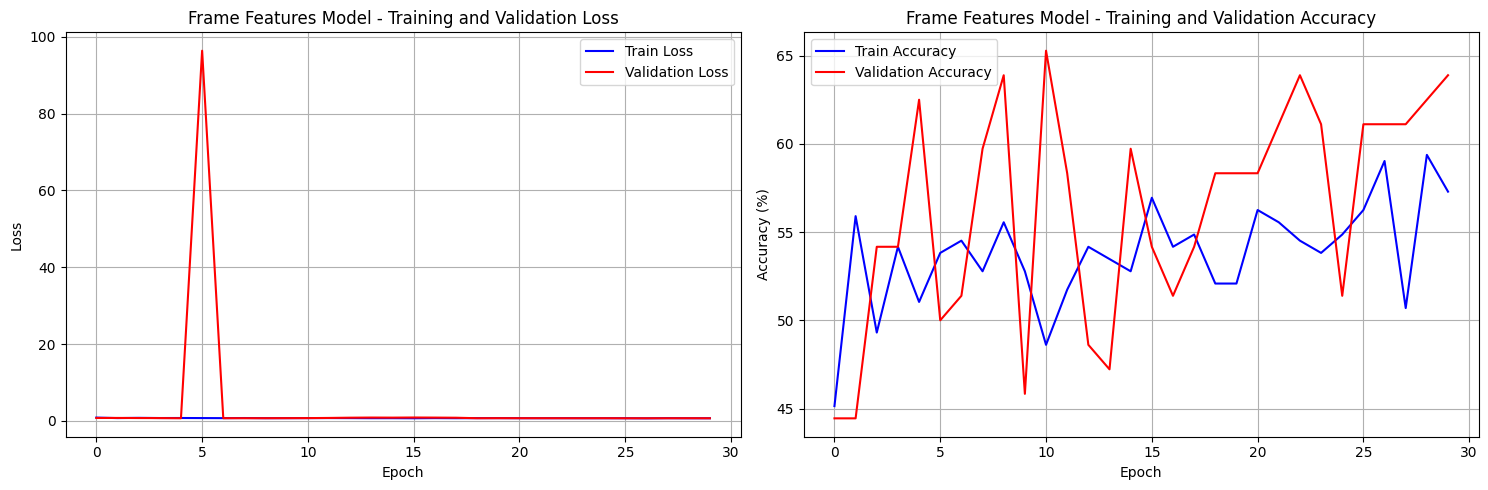

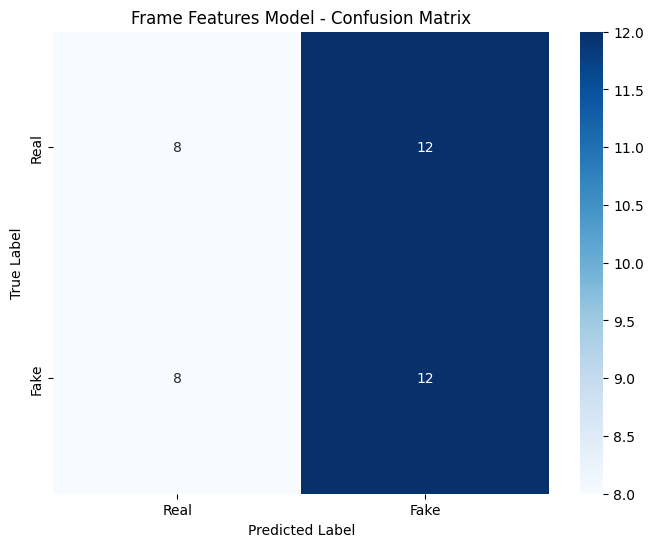

In [33]:
# Plot training history for frame model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(frame_results['train_losses'], label='Train Loss', color='blue')
ax1.plot(frame_results['val_losses'], label='Validation Loss', color='red')
ax1.set_title('Frame Features Model - Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(frame_results['train_accuracies'], label='Train Accuracy', color='blue')
ax2.plot(frame_results['val_accuracies'], label='Validation Accuracy', color='red')
ax2.set_title('Frame Features Model - Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Frame Features Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [35]:
print("=" * 50)
print("TRAINING MODEL WITH TEMPORAL FEATURES")
print("=" * 50)

# Create datasets for temporal features
train_temporal_dataset = DeepfakeDataset(train_split, feature_type='temporal_features')
val_temporal_dataset = DeepfakeDataset(val_split, feature_type='temporal_features')
test_temporal_dataset = DeepfakeDataset(test_data, feature_type='temporal_features')

# Create data loaders
batch_size = 16
train_temporal_loader = DataLoader(train_temporal_dataset, batch_size=batch_size, shuffle=True)
val_temporal_loader = DataLoader(val_temporal_dataset, batch_size=batch_size, shuffle=False)
test_temporal_loader = DataLoader(test_temporal_dataset, batch_size=batch_size, shuffle=False)

# Get input size for temporal features
input_size_temporal = train_temporal_dataset[0][0].shape[0]
print(f"Input feature size (temporal): {input_size_temporal}")

# Create model
model_temporal = DeepfakeDetectionModel(input_size_temporal).to(DEVICE)
criterion_temporal = nn.CrossEntropyLoss()
optimizer_temporal = optim.Adam(model_temporal.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_temporal = optim.lr_scheduler.StepLR(optimizer_temporal, step_size=10, gamma=0.5)

# Training loop
epochs = 30
train_losses_temporal = []
val_losses_temporal = []
train_accuracies_temporal = []
val_accuracies_temporal = []
best_val_acc_temporal = 0

print("Starting training (temporal features)...")
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model_temporal, train_temporal_loader, criterion_temporal, optimizer_temporal, DEVICE)
    val_loss, val_acc = validate_epoch(model_temporal, val_temporal_loader, criterion_temporal, DEVICE)
    
    train_losses_temporal.append(train_loss)
    val_losses_temporal.append(val_loss)
    train_accuracies_temporal.append(train_acc)
    val_accuracies_temporal.append(val_acc)
    
    scheduler_temporal.step()
    
    if val_acc > best_val_acc_temporal:
        best_val_acc_temporal = val_acc
        torch.save(model_temporal.state_dict(), f'{OUTPUT_DIR}/best_temporal_model.pth')
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print(f'Best validation accuracy (temporal): {best_val_acc_temporal:.2f}%')

# Test the model
accuracy_temporal, precision_temporal, recall_temporal, f1_temporal, true_labels_temporal, predictions_temporal = test_model(
    model_temporal, test_temporal_loader, DEVICE
)

print(f"\nTemporal Features Model Test Results:")
print(f"Accuracy: {accuracy_temporal:.4f}")
print(f"Precision: {precision_temporal:.4f}")
print(f"Recall: {recall_temporal:.4f}")
print(f"F1-Score: {f1_temporal:.4f}")

# Store results
temporal_results = {
    'accuracy': accuracy_temporal,
    'precision': precision_temporal,
    'recall': recall_temporal,
    'f1': f1_temporal,
    'train_losses': train_losses_temporal,
    'val_losses': val_losses_temporal,
    'train_accuracies': train_accuracies_temporal,
    'val_accuracies': val_accuracies_temporal
}

TRAINING MODEL WITH TEMPORAL FEATURES
Input feature size (temporal): 50
Starting training (temporal features)...


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/30:
  Train Loss: 0.7763, Train Acc: 48.96%
  Val Loss: 0.6819, Val Acc: 50.00%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/30:
  Train Loss: 0.7130, Train Acc: 51.39%
  Val Loss: 0.6316, Val Acc: 56.94%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/30:
  Train Loss: 0.6632, Train Acc: 54.86%
  Val Loss: 0.6360, Val Acc: 59.72%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/30:
  Train Loss: 0.6565, Train Acc: 57.29%
  Val Loss: 0.6311, Val Acc: 56.94%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/30:
  Train Loss: 0.6342, Train Acc: 63.19%
  Val Loss: 0.6509, Val Acc: 59.72%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/30:
  Train Loss: 0.6241, Train Acc: 60.76%
  Val Loss: 0.6363, Val Acc: 59.72%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Best validation accuracy (temporal): 63.89%


Testing:   0%|          | 0/3 [00:00<?, ?it/s]


Temporal Features Model Test Results:
Accuracy: 0.5250
Precision: 0.5185
Recall: 0.7000
F1-Score: 0.5957


In [36]:
# Since you have already trained and evaluated models with frame and temporal features,
# a logical next step is to train and evaluate a model using the 'combined' feature set.

print("=" * 50)
print("TRAINING MODEL WITH COMBINED FEATURES")
print("=" * 50)

# Create datasets for combined features
train_combined_dataset = DeepfakeDataset(train_split, feature_type='combined')
val_combined_dataset = DeepfakeDataset(val_split, feature_type='combined')
test_combined_dataset = DeepfakeDataset(test_data, feature_type='combined')

# Create data loaders
batch_size = 16
train_combined_loader = DataLoader(train_combined_dataset, batch_size=batch_size, shuffle=True)
val_combined_loader = DataLoader(val_combined_dataset, batch_size=batch_size, shuffle=False)
test_combined_loader = DataLoader(test_combined_dataset, batch_size=batch_size, shuffle=False)

# Get input size for combined features
input_size_combined = train_combined_dataset[0][0].shape[0]
print(f"Input feature size (combined): {input_size_combined}")

# Create model
model_combined = DeepfakeDetectionModel(input_size_combined).to(DEVICE)
criterion_combined = nn.CrossEntropyLoss()
optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_combined = optim.lr_scheduler.StepLR(optimizer_combined, step_size=10, gamma=0.5)

# Training loop
epochs = 30
train_losses_combined = []
val_losses_combined = []
train_accuracies_combined = []
val_accuracies_combined = []
best_val_acc_combined = 0

print("Starting training (combined features)...")
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model_combined, train_combined_loader, criterion_combined, optimizer_combined, DEVICE)
    val_loss, val_acc = validate_epoch(model_combined, val_combined_loader, criterion_combined, DEVICE)
    
    train_losses_combined.append(train_loss)
    val_losses_combined.append(val_loss)
    train_accuracies_combined.append(train_acc)
    val_accuracies_combined.append(val_acc)
    
    scheduler_combined.step()
    
    if val_acc > best_val_acc_combined:
        best_val_acc_combined = val_acc
        torch.save(model_combined.state_dict(), f'{OUTPUT_DIR}/best_combined_model.pth')
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print(f'Best validation accuracy (combined): {best_val_acc_combined:.2f}%')

# Test the model
accuracy_combined, precision_combined, recall_combined, f1_combined, true_labels_combined, predictions_combined = test_model(
    model_combined, test_combined_loader, DEVICE
)

print(f"\nCombined Features Model Test Results:")
print(f"Accuracy: {accuracy_combined:.4f}")
print(f"Precision: {precision_combined:.4f}")
print(f"Recall: {recall_combined:.4f}")
print(f"F1-Score: {f1_combined:.4f}")

# Store results
combined_results = {
    'accuracy': accuracy_combined,
    'precision': precision_combined,
    'recall': recall_combined,
    'f1': f1_combined,
    'train_losses': train_losses_combined,
    'val_losses': val_losses_combined,
    'train_accuracies': train_accuracies_combined,
    'val_accuracies': val_accuracies_combined
}

TRAINING MODEL WITH COMBINED FEATURES
Input feature size (combined): 350
Starting training (combined features)...


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/30:
  Train Loss: 0.7961, Train Acc: 52.08%
  Val Loss: 0.7115, Val Acc: 45.83%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/30:
  Train Loss: 0.6817, Train Acc: 57.29%
  Val Loss: 0.7045, Val Acc: 51.39%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/30:
  Train Loss: 0.7106, Train Acc: 52.08%
  Val Loss: 0.6993, Val Acc: 59.72%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/30:
  Train Loss: 0.6880, Train Acc: 56.94%
  Val Loss: 0.6783, Val Acc: 55.56%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/30:
  Train Loss: 0.6741, Train Acc: 56.25%
  Val Loss: 0.6831, Val Acc: 55.56%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/30:
  Train Loss: 0.6904, Train Acc: 54.17%
  Val Loss: 0.6772, Val Acc: 62.50%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Best validation accuracy (combined): 66.67%


Testing:   0%|          | 0/3 [00:00<?, ?it/s]


Combined Features Model Test Results:
Accuracy: 0.4500
Precision: 0.4545
Recall: 0.5000
F1-Score: 0.4762


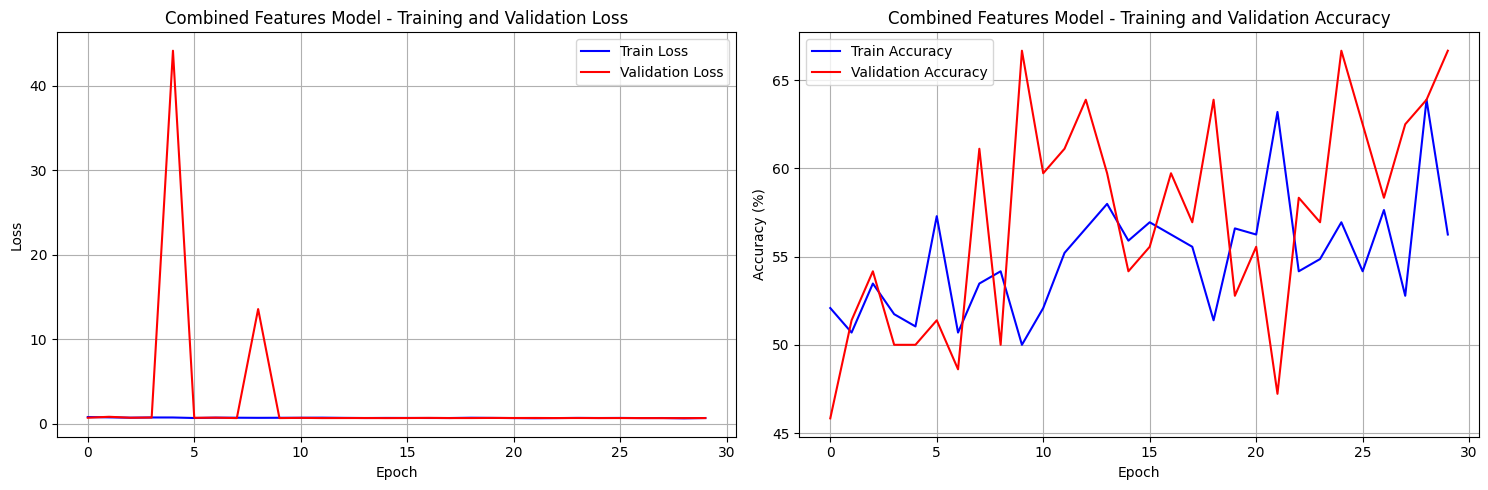

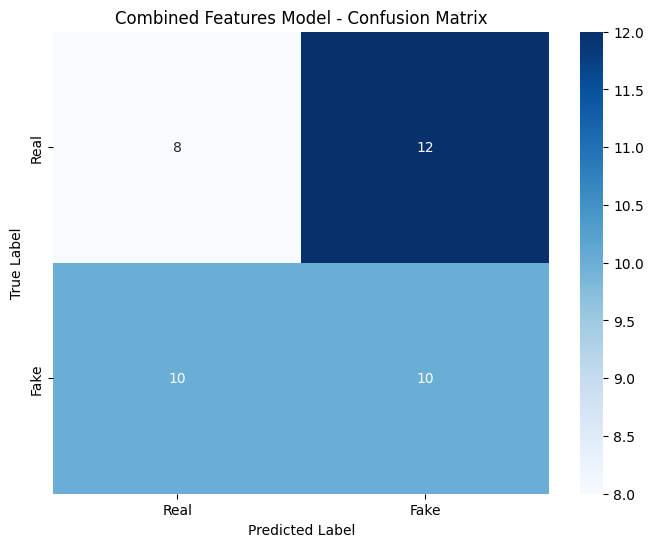

In [37]:
# Plot training and validation loss/accuracy for the combined features model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(combined_results['train_losses'], label='Train Loss', color='blue')
ax1.plot(combined_results['val_losses'], label='Validation Loss', color='red')
ax1.set_title('Combined Features Model - Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(combined_results['train_accuracies'], label='Train Accuracy', color='blue')
ax2.plot(combined_results['val_accuracies'], label='Validation Accuracy', color='red')
ax2.set_title('Combined Features Model - Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix for combined features model
cm_combined = confusion_matrix(true_labels_combined, predictions_combined)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Combined Features Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-Score
0,Frame Features,0.500,0.500000,0.6,0.545455
1,Temporal Features,0.525,0.518519,0.7,0.595745
2,Combined Features,0.450,0.454545,0.5,0.476190


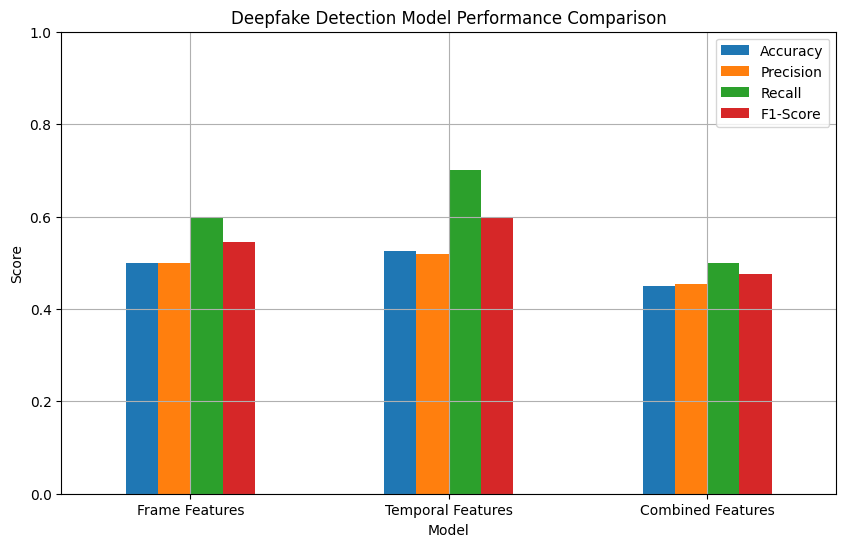

In [38]:
# Since you have already trained and evaluated models with frame, temporal, and combined features,
# a good next step is to compare the performance of all three models side by side.

# Create a summary DataFrame for easy comparison
results_df = pd.DataFrame({
    'Model': ['Frame Features', 'Temporal Features', 'Combined Features'],
    'Accuracy': [frame_results['accuracy'], temporal_results['accuracy'], combined_results['accuracy']],
    'Precision': [frame_results['precision'], temporal_results['precision'], combined_results['precision']],
    'Recall': [frame_results['recall'], temporal_results['recall'], combined_results['recall']],
    'F1-Score': [frame_results['f1'], temporal_results['f1'], combined_results['f1']]
})

print("Model Performance Comparison:")
display(results_df)

# Optionally, plot the comparison
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(10, 6), ylim=(0, 1), grid=True, rot=0
)
plt.title('Deepfake Detection Model Performance Comparison')
plt.ylabel('Score')
plt.show()

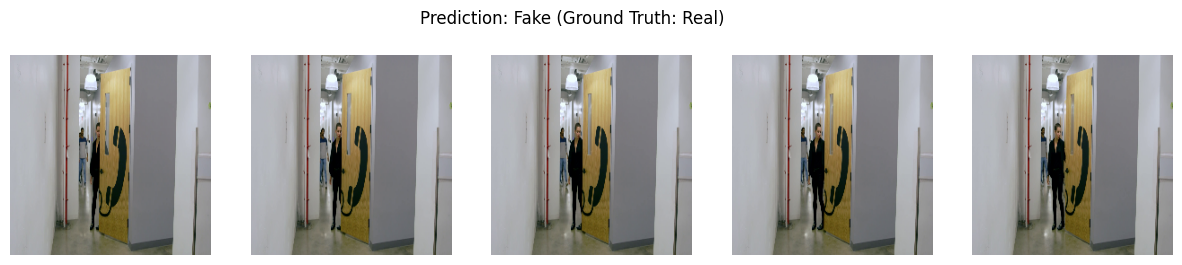

In [50]:
# Pick a sample video from the test set
sample_video = test_data[0]  # You can change the index to test other videos

# Extract features for the sample video using the same pipeline
features = []
for frame in sample_video['frames']:
    frame_feat = list(frame['frame_features'].values())
    features.extend(frame_feat)
temporal_features = list(sample_video['temporal_features'].values())
temporal_features = [f if not np.isnan(f) else 0 for f in temporal_features]
# Pad or truncate to match the input size of the temporal model
target_size = 50
if len(temporal_features) < target_size:
    temporal_features.extend([0] * (target_size - len(temporal_features)))
else:
    temporal_features = temporal_features[:target_size]
input_tensor = torch.FloatTensor(temporal_features).unsqueeze(0).to(DEVICE)

# Predict using the trained temporal model
model_temporal.eval()
with torch.no_grad():
    output = model_temporal(input_tensor)
    pred_label = torch.argmax(output, dim=1).item()

# Display the video frames and prediction result
import matplotlib.pyplot as plt

# Re-extract the actual frame images from the video file for visualization
video_path = sample_video['path']
frame_images = extract_frames_from_video(video_path, max_frames=5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    if i < len(frame_images):
        ax.imshow(cv2.cvtColor(frame_images[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')
    else:
        ax.remove()
plt.suptitle(f"Prediction: {'Fake' if pred_label == 1 else 'Real'} (Ground Truth: {'Fake' if sample_video['label'] == 1 else 'Real'})")
plt.show()

In [54]:
# Path to your new video
new_video_path = r'deepfake_dataset\train\real\01__hugging_happy.mp4'  # <-- Change this to your actual video path

# Extract frames and features for the new video
frames = extract_frames_from_video(new_video_path)
if not frames:
    print("No frames extracted from the video.")
else:
    # Extract frame-level features
    frame_features = []
    for frame in frames:
        frame_feat = list(calculate_frame_features(frame).values())
        frame_features.extend(frame_feat)
    
    # Pad/truncate for frame model
    frame_input = frame_features[:300] if len(frame_features) >= 300 else frame_features + [0] * (300 - len(frame_features))
    frame_input_tensor = torch.FloatTensor(frame_input).unsqueeze(0).to(DEVICE)
    
    # Extract temporal features
    # For this, we need to extract landmarks and pose as well
    all_facial_landmarks = []
    all_pose_landmarks = []
    all_frame_features = []
    for frame in frames:
        landmarks = extract_facial_landmarks(frame, preprocessor)
        pose = extract_pose_landmarks(frame, preprocessor)
        all_frame_features.append(calculate_frame_features(frame))
        if landmarks.get('mediapipe') is not None:
            all_facial_landmarks.append(landmarks['mediapipe'])
        if pose is not None:
            all_pose_landmarks.append(pose)
    temporal_features = calculate_temporal_features(all_facial_landmarks, all_pose_landmarks, all_frame_features)
    temporal_feat_list = list(temporal_features.values())
    temporal_feat_list = [f if not np.isnan(f) else 0 for f in temporal_feat_list]
    temporal_input = temporal_feat_list[:50] if len(temporal_feat_list) >= 50 else temporal_feat_list + [0] * (50 - len(temporal_feat_list))
    temporal_input_tensor = torch.FloatTensor(temporal_input).unsqueeze(0).to(DEVICE)
    
    # Combined features
    combined_input = frame_input + temporal_input
    combined_input = combined_input[:350] if len(combined_input) >= 350 else combined_input + [0] * (350 - len(combined_input))
    combined_input_tensor = torch.FloatTensor(combined_input).unsqueeze(0).to(DEVICE)
    
    # Set models to eval mode
    model_frame.eval()
    model_temporal.eval()
    model_combined.eval()
    
    with torch.no_grad():
        out_frame = model_frame(frame_input_tensor)
        pred_frame = torch.argmax(out_frame, dim=1).item()
        
        out_temporal = model_temporal(temporal_input_tensor)
        pred_temporal = torch.argmax(out_temporal, dim=1).item()
        
        out_combined = model_combined(combined_input_tensor)
        pred_combined = torch.argmax(out_combined, dim=1).item()
    
    label_map = {0: 'Real', 1: 'Fake'}
    print("Predictions for new video:")
    print(f"  Frame Features Model: {label_map[pred_frame]}")
    print(f"  Temporal Features Model: {label_map[pred_temporal]}")
    print(f"  Combined Features Model: {label_map[pred_combined]}")

Predictions for new video:
  Frame Features Model: Fake
  Temporal Features Model: Real
  Combined Features Model: Fake


In [55]:
# Suggestions to improve model accuracy

# 1. Feature Engineering: Try adding more discriminative features or use feature selection.
# 2. Model Architecture: Use deeper/wider networks, or try other architectures (e.g., CNNs, RNNs for temporal data).
# 3. Data Augmentation: Augment frames (flip, rotate, color jitter) to increase data diversity.
# 4. Hyperparameter Tuning: Tune learning rate, batch size, optimizer, dropout, etc.
# 5. Training Epochs: Train for more epochs and use early stopping.
# 6. Class Imbalance: Use class weights or oversample minority class if data is imbalanced.
# 7. Pretrained Models: Use pretrained CNNs (e.g., ResNet) for frame feature extraction.
# 8. Ensemble: Combine predictions from multiple models.

# Example: Add data augmentation and try a deeper model

import torchvision.transforms as T

# Data augmentation for frames
augment = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor()
])

def extract_frames_from_video_augmented(video_path, max_frames=30, target_fps=10):
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = max(1, int(fps / target_fps)) if fps > 0 else 1
    frames = []
    frame_count = 0
    extracted_count = 0
    while cap.isOpened() and extracted_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame = cv2.resize(frame, (224, 224))
            # Apply augmentation
            frame_aug = augment(frame)
            frame_aug = (frame_aug.permute(1, 2, 0).numpy() * 255).astype('uint8')
            frames.append(frame_aug)
            extracted_count += 1
        frame_count += 1
    cap.release()
    return frames

# Example: Deeper model
class DeepfakeDetectionModelV2(nn.Module):
    def __init__(self, input_size, hidden_sizes=[1024, 512, 256, 128], dropout=0.4):
        super().__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout)
            ])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 2))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)

print("Try these improvements and retrain your models for better accuracy.")

Try these improvements and retrain your models for better accuracy.


In [56]:
# Test the deeper model (DeepfakeDetectionModelV2) on the combined features test set

# Instantiate the deeper model with the same input size as the combined features
input_size_combined = train_combined_dataset[0][0].shape[0]
deeper_model = DeepfakeDetectionModelV2(input_size_combined).to(DEVICE)

# Load the best weights if you have saved them, otherwise train from scratch
# Example: deeper_model.load_state_dict(torch.load(f'{OUTPUT_DIR}/best_deeper_combined_model.pth'))

# Define loss and optimizer
criterion_deeper = nn.CrossEntropyLoss()
optimizer_deeper = optim.Adam(deeper_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_deeper = optim.lr_scheduler.StepLR(optimizer_deeper, step_size=10, gamma=0.5)

# Training loop for deeper model
epochs = 30
train_losses_deeper = []
val_losses_deeper = []
train_accuracies_deeper = []
val_accuracies_deeper = []
best_val_acc_deeper = 0

print("=" * 50)
print("TRAINING DEEPER MODEL WITH COMBINED FEATURES")
print("=" * 50)

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(deeper_model, train_combined_loader, criterion_deeper, optimizer_deeper, DEVICE)
    val_loss, val_acc = validate_epoch(deeper_model, val_combined_loader, criterion_deeper, DEVICE)
    
    train_losses_deeper.append(train_loss)
    val_losses_deeper.append(val_loss)
    train_accuracies_deeper.append(train_acc)
    val_accuracies_deeper.append(val_acc)
    
    scheduler_deeper.step()
    
    if val_acc > best_val_acc_deeper:
        best_val_acc_deeper = val_acc
        torch.save(deeper_model.state_dict(), f'{OUTPUT_DIR}/best_deeper_combined_model.pth')
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print(f'Best validation accuracy (deeper combined): {best_val_acc_deeper:.2f}%')

# Test the deeper model
accuracy_deeper, precision_deeper, recall_deeper, f1_deeper, true_labels_deeper, predictions_deeper = test_model(
    deeper_model, test_combined_loader, DEVICE
)

print(f"\nDeeper Combined Features Model Test Results:")
print(f"Accuracy: {accuracy_deeper:.4f}")
print(f"Precision: {precision_deeper:.4f}")
print(f"Recall: {recall_deeper:.4f}")
print(f"F1-Score: {f1_deeper:.4f}")

# Store results
deeper_combined_results = {
    'accuracy': accuracy_deeper,
    'precision': precision_deeper,
    'recall': recall_deeper,
    'f1': f1_deeper,
    'train_losses': train_losses_deeper,
    'val_losses': val_losses_deeper,
    'train_accuracies': train_accuracies_deeper,
    'val_accuracies': val_accuracies_deeper
}

TRAINING DEEPER MODEL WITH COMBINED FEATURES


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/30:
  Train Loss: 0.8723, Train Acc: 47.92%
  Val Loss: 0.7049, Val Acc: 58.33%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/30:
  Train Loss: 0.7772, Train Acc: 48.26%
  Val Loss: 0.6810, Val Acc: 61.11%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/30:
  Train Loss: 0.7196, Train Acc: 53.47%
  Val Loss: 0.6638, Val Acc: 58.33%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/30:
  Train Loss: 0.6967, Train Acc: 51.39%
  Val Loss: 0.6969, Val Acc: 61.11%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/30:
  Train Loss: 0.6842, Train Acc: 57.64%
  Val Loss: 0.6897, Val Acc: 59.72%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/30:
  Train Loss: 0.6944, Train Acc: 53.47%
  Val Loss: 0.6794, Val Acc: 63.89%


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Best validation accuracy (deeper combined): 69.44%


Testing:   0%|          | 0/3 [00:00<?, ?it/s]


Deeper Combined Features Model Test Results:
Accuracy: 0.4750
Precision: 0.4762
Recall: 0.5000
F1-Score: 0.4878


In [59]:
# Path to your new local video (update this path as needed)
new_video_path = r'deepfake_dataset\train\real\01__outside_talking_still_laughing.mp4'  # Change to your actual video path

# Extract frames from the new video
frames = extract_frames_from_video(new_video_path)
if not frames:
    print("No frames extracted from the video.")
else:
    # Extract frame-level features
    frame_features = []
    for frame in frames:
        frame_feat = list(calculate_frame_features(frame).values())
        frame_features.extend(frame_feat)
    
    # Pad/truncate for frame model
    frame_input = frame_features[:300] if len(frame_features) >= 300 else frame_features + [0] * (300 - len(frame_features))
    frame_input_tensor = torch.FloatTensor(frame_input).unsqueeze(0).to(DEVICE)
    
    # Extract temporal features
    all_facial_landmarks = []
    all_pose_landmarks = []
    all_frame_features = []
    for frame in frames:
        landmarks = extract_facial_landmarks(frame, preprocessor)
        pose = extract_pose_landmarks(frame, preprocessor)
        all_frame_features.append(calculate_frame_features(frame))
        if landmarks.get('mediapipe') is not None:
            all_facial_landmarks.append(landmarks['mediapipe'])
        if pose is not None:
            all_pose_landmarks.append(pose)
    temporal_features = calculate_temporal_features(all_facial_landmarks, all_pose_landmarks, all_frame_features)
    temporal_feat_list = list(temporal_features.values())
    temporal_feat_list = [f if not np.isnan(f) else 0 for f in temporal_feat_list]
    temporal_input = temporal_feat_list[:50] if len(temporal_feat_list) >= 50 else temporal_feat_list + [0] * (50 - len(temporal_feat_list))
    temporal_input_tensor = torch.FloatTensor(temporal_input).unsqueeze(0).to(DEVICE)
    
    # Combined features
    combined_input = frame_input + temporal_input
    combined_input = combined_input[:350] if len(combined_input) >= 350 else combined_input + [0] * (350 - len(combined_input))
    combined_input_tensor = torch.FloatTensor(combined_input).unsqueeze(0).to(DEVICE)
    
    # Set models to eval mode
    model_frame.eval()
    model_temporal.eval()
    model_combined.eval()
    
    with torch.no_grad():
        out_frame = model_frame(frame_input_tensor)
        pred_frame = torch.argmax(out_frame, dim=1).item()
        
        out_temporal = model_temporal(temporal_input_tensor)
        pred_temporal = torch.argmax(out_temporal, dim=1).item()
        
        out_combined = model_combined(combined_input_tensor)
        pred_combined = torch.argmax(out_combined, dim=1).item()
    
    label_map = {0: 'Real', 1: 'Fake'}
    print("Predictions for new video:")
    print(f"  Frame Features Model: {label_map[pred_frame]}")
    print(f"  Temporal Features Model: {label_map[pred_temporal]}")
    print(f"  Combined Features Model: {label_map[pred_combined]}")

Predictions for new video:
  Frame Features Model: Fake
  Temporal Features Model: Real
  Combined Features Model: Fake
